# 4장 - 평가와 최적화

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


두 개의 입력을 생성한다. 

* 특성 - 입력 특성의 행렬
* 목표 - 이러한 특성에 상응하는 목표 변수의 배열

In [2]:
features = rand(100,5)
target = rand(100) > 0.5

### 홀드아웃 메소드

무작위로 훈련셋 테스트셋으로 나눈다.

In [3]:
N = features.shape[0]
N_train = floor(0.7 * N)

# 인덱스를 무작위하게 만든다.
# 주의: 경우에따라서 데이터셋에서 순서를 유지하려면 이 단계를 건너뛰기를 바란다. 
# 예, '이후의' 사례를 테스트하려는 시간 기반 데이터셋일 경우
idx = random.permutation(N)

# 인덱스를 분할한다. 
idx_train = idx[:int(N_train)]
idx_test = idx[int(N_train):]

# 데이터를 훈련용 부분집합과 테스트용 부분집합으로 끊어 나눈다.
features_train = features[idx_train,:]
target_train = target[idx_train]
features_test = features[idx_test,:]
target_test = target[idx_test]

# 구축, 예측, 평가(보강해 나갈 내용)
# model = train(features_train, target_train)
# preds_test = predict(model, features_test)
# accuracy = evaluate_acc(preds_test, target_test)

In [4]:
print features_train.shape
print features_test.shape
print target_train.shape
print target_test.shape

(70L, 5L)
(30L, 5L)
(70L,)
(30L,)


### K-겹 교차 검증

In [11]:
N = features.shape[0]
K = 10 # 겹 개수

preds_kfold = np.empty(N)
folds = np.random.randint(0, K, size=N)

for idx in np.arange(K):

    # 각 겹마다 데이터를 훈련 부분집합과 테스트 부분집합으로 나눈다.
    features_train = features[folds != idx,:]
    target_train = target[folds != idx]
    features_test = features[folds == idx,:]
    
    # 검사하기 위해서 각 겹의 인덱스를 출력한다. 
    print nonzero(folds == idx)[0]

    # 교차 검증용 겹들을 구축하고 예측(보강해 나갈 내용)   
    # model = train(features_train, target_train)
    # preds_kfold[folds == idx] = predict(model, features_test)
    
# accuracy = evaluate_acc(preds_kfold, target)

[ 0 13 28 30 35 45 55 77 78]
[ 1  2 44 58 61 76 80 85]
[22 32 33 53 87 99]
[ 3  8 11 15 24 29 31 50 54 62 64 65 73 83 92]
[ 5 16 19 38 43 47 51 56 57 66 67 69 74 86 91 94 97]
[ 7 14 26 27 37 39 40 63 68 72 90 96 98]
[ 6 12 18 23 25 42 52]
[17 21 46 48 49 60 71 82]
[ 9 36 79 81 84 88 89 93]
[ 4 10 20 34 41 59 70 75 95]


### ROC 곡선

In [12]:
def roc_curve(true_labels, predicted_probs, n_points=100, pos_class=1):
    thr = linspace(0,1,n_points)
    tpr = zeros(n_points)
    fpr = zeros(n_points)

    pos = true_labels == pos_class
    neg = logical_not(pos)
    n_pos = count_nonzero(pos)
    n_neg = count_nonzero(neg)
      
    for i,t in enumerate(thr):
        tpr[i] = count_nonzero(logical_and(predicted_probs >= t, pos)) / n_pos
        fpr[i] = count_nonzero(logical_and(predicted_probs >= t, neg)) / n_neg
    
    return fpr, tpr, thr


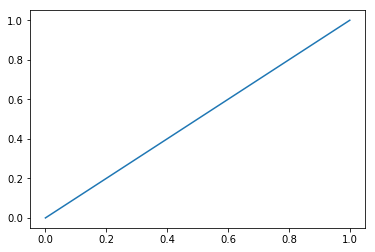

In [13]:
# 임의로 생성된 예측은 ROC 곡선이 대각선이다. 
preds = rand(len(target))
fpr, tpr, thr = roc_curve(target, preds, pos_class=True)
plot(fpr, tpr)

### ROC 곡선 아래 영역

In [14]:
def auc(true_labels, predicted_labels, pos_class=1):
    fpr, tpr, thr = roc_curve(true_labels, predicted_labels,
 pos_class=pos_class)
    area = -trapz(tpr, x=fpr)
    return area

In [15]:
auc(target, preds, pos_class=True)

0.5

### 다중 계급 분류 

In [16]:
import pandas
d = pandas.read_csv("data/mnist_small.csv")
d_train = d[:int(0.8*len(d))]
d_test = d[int(0.8*len(d)):]

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(d_train.drop('label', axis=1), d_train['label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [18]:
from sklearn.metrics import confusion_matrix
preds = rf.predict(d_test.drop('label', axis=1))
cm = confusion_matrix(d_test['label'], preds)

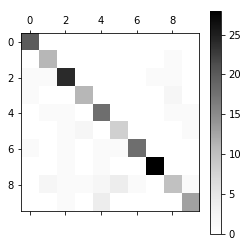

In [19]:
matshow(cm, cmap='Greys')
colorbar()
savefig("data/figure-4.19.eps", format='eps')

### 제곱근 평균 제곱 오차

In [20]:
def rmse(true_values, predicted_values):
    n = len(true_values)
    residuals = 0
    for i in range(n):
        residuals += (true_values[i] - predicted_values[i])**2.
    return np.sqrt(residuals/n)

In [21]:
rmse(rand(10), rand(10))

0.23511881045084959

### R 제곱 오차

In [22]:
def r2(true_values, predicted_values):
    n = len(true_values)
    mean = np.mean(true_values)
    residuals = 0
    total = 0
    for i in range(n):
        residuals += (true_values[i] - predicted_values[i])**2.
        total += (true_values[i] - mean)**2.
    return 1.0 - residuals/total

In [23]:
r2(arange(10)+rand(), arange(10)+rand(10))

0.99002087110985038

### 커널 서포트 벡터 머신 모델을 이용한 그리드 탐색 

모듈 가져오기

In [24]:
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

데이터를 가져오고 아주 간단하게 특성 공학 수행하기

In [25]:
d = pandas.read_csv("data/titanic.csv")

# Target
# 목표
y = d["Survived"]

# Features
# 특성
X = d.drop(["Survived", "PassengerId", "Cabin","Ticket","Name", "Fare"], axis=1)
X['Sex'] = map(lambda x: 1 if x=="male" else 0, X['Sex'])
X['Embarked-Q'] = map(lambda x: 1 if x=="Q" else 0, X['Embarked'])
X['Embarked-C'] = map(lambda x: 1 if x=="C" else 0, X['Embarked'])
X['Embarked-S'] = map(lambda x: 1 if x=="S" else 0, X['Embarked'])
X = X.drop(["Embarked", "Sex"], axis=1)
X = X.fillna(-1)

최적의 하이퍼 매개변수를 찾기 위해서 그리드 탐색을 수행하기

In [27]:
# 시도할 (감마, C) 값들로 구성된 그리드 
gam_vec, cost_vec = np.meshgrid(np.linspace(0.01, 10, 11),
                     np.linspace(0.01, 10, 11))

AUC_all = [] # AUC 결과를 저장하기 위해 빈 배열을 초기화한다.

# 교차 검증 겹들을 설정 
N = len(y)
K = 10 # 교차 검증 겹 수
folds = np.random.randint(0, K, size=N)

# 그리드를 이루는 모든 값을 탐색 
for param_ind in np.arange(len(gam_vec.ravel())):

    # 교차 검증 예측들을 초기화
    y_cv_pred = np.empty(N)

    # 교차 검증 겹들을 반복순회(loop)
    for ii in np.arange(K):
        # 데이터를 훈련용 부분집합과 테스트용 부분집합으로 나눔
        X_train = X.ix[folds != ii,:]
        y_train = y.ix[folds != ii]
        X_test = X.ix[folds == ii,:]

        # 훈련용 집합을 바탕으로 해서 모델 한 개를 구축
        model = SVC(gamma=gam_vec.ravel()[param_ind], C=cost_vec.ravel()[param_ind])
        model.fit(X_train, y_train)

        # 훈련용 집합을 바탕으로 모델 예측들을 생성하고 저장
        y_cv_pred[folds == ii] = model.predict(X_test)

    # 예측 AUC를 평가
    AUC_all.append(roc_auc_score(y, y_cv_pred))

indmax = np.argmax(AUC_all)
print "Maximum = %.3f" % (np.max(AUC_all))
print "Tuning Parameters: (gamma = %.2f, C = %.2f)" % (gam_vec.ravel()[indmax], cost_vec.ravel()[indmax])

Maximum = 0.674
Tuning Parameters: (gamma = 0.01, C = 8.00)


매개변수 성능에 대한 등고선 그림

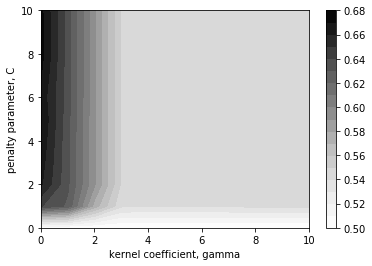

In [28]:
AUC_grid = np.array(AUC_all).reshape(gam_vec.shape)

contourf(gam_vec, cost_vec, AUC_grid, 20, cmap='Greys')
xlabel("kernel coefficient, gamma")
ylabel("penalty parameter, C")
colorbar()
savefig("data/figure-4.25.eps", format='eps')